In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, time
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from difflib import SequenceMatcher
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from statsmodels.regression.linear_model import OLSResults

In [3]:
df = pd.read_csv("between-patch.csv")
pd.set_option('display.max_columns', None)

In [4]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_count = p.sub('',  df.loc[ind, "Title"])
    description_count = p.sub('',  df.loc[ind, "Body"])
    df.loc[ind, "Words_in_Title"] = len(re.findall(r'\w+',title_count))
    df.loc[ind, "Words_in_Title_Description"] = len(re.findall(r'\w+',description_count))

In [5]:
pattern = "<"

for ind, row in df.iterrows():
    df.loc[ind,"Tags_Count"] = len(re.findall(pattern, df.loc[ind,"Tags"]))

In [6]:
for ind , row in df.iterrows():
    title = df.loc[ind,"Title"]
    tag = re.sub(r'[^\w]', ' ', df.loc[ind, "Tags"])
#     print(format((SequenceMatcher(None, title,tag).ratio()*100),".2f"),"%")
    df.loc[ind, "title_tag_ratio"] = format((SequenceMatcher(None, title,tag).ratio()*100),".2f")

In [7]:
df['Tags_Count'] = df['Tags_Count'].astype(int)
df['Words_in_Title_Description'] = df['Words_in_Title_Description'].astype(int)

In [8]:
df.drop(['Id','Score','Title','ViewCount','FavoriteCount','Body','Tags','CreationDate','LastActivityDate','LastEditDate','Auth_reputation','Editor_reputation','AcceptedAnswerId','Words_in_Title','title_tag_ratio','ClosedDate'], axis=1, inplace=True)

In [11]:
data_scaled = normalize(df)

In [12]:
hc = AgglomerativeClustering(n_clusters=2,affinity="euclidean",linkage="ward")
hc.fit(data_scaled)

AgglomerativeClustering()

In [13]:
membership = hc.labels_
membership

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [14]:
df_0 = df[hc.labels_==0]

In [15]:
df_1 = df[hc.labels_==1]

In [26]:
cost0 = df_0.sort_values(['AnswerCount'], ascending=[False])

In [27]:
cost0.head(5)

,AnswerCount,CommentCount,Words_in_Title_Description,Tags_Count
137,97,7,131,3
459,86,0,45,5
21,50,2,36,2
1865,44,13,264,3
92,41,2,56,1


In [28]:
cost1 = df_1.sort_values(['AnswerCount'], ascending=[False])

In [29]:
cost1.head(5)

,AnswerCount,CommentCount,Words_in_Title_Description,Tags_Count
4345,18,4,202,3
325,14,3,400,3
2063,13,0,204,2
2771,12,2,176,4
2767,11,1,143,3


In [9]:
df_first = pd.read_csv("between_cost_low.csv")

In [10]:
df_second = pd.read_csv("between_cost_high.csv")

In [11]:
df_first.head(1)

,Unnamed: 0,AnswerCount,CommentCount,Words_in_Title_Description,Tags_Count
0,0,1,0,162,4


In [12]:
feature_names = ["AnswerCount", "CommentCount", "Words_in_Title_Description", "Tags_Count"]
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]

In [13]:
scaler = MinMaxScaler()
features = df_first[feature_names]
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]
scaler.fit(features)
for i in nrm_feature_names:
    df_first[i] = 0
df_first[nrm_feature_names] = scaler.transform(features)
df_first["Sum_of_features"] = df_first[nrm_feature_names].sum(axis=1)

In [14]:
scaler = MinMaxScaler()
features = df_second[feature_names]
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]
scaler.fit(features)
for i in nrm_feature_names:
    df_second[i] = 0
df_second[nrm_feature_names] = scaler.transform(features)
df_second["Sum_of_features"] = df_second[nrm_feature_names].sum(axis=1)

In [23]:
lower_quantile, upper_quantile = df_first["Sum_of_features"].quantile([.25, .75])

df_one_adjusted = df_first.loc[(df_first["Sum_of_features"] < lower_quantile) | (df_first["Sum_of_features"] > upper_quantile)]

In [22]:
lower_quantile, upper_quantile = df_second["Sum_of_features"].quantile([.25, .75])

df_two_adjusted = df_second.loc[(df_second["Sum_of_features"] < lower_quantile) | (df_second["Sum_of_features"] > upper_quantile)]

c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sum_of_features', ylabel='Density'>

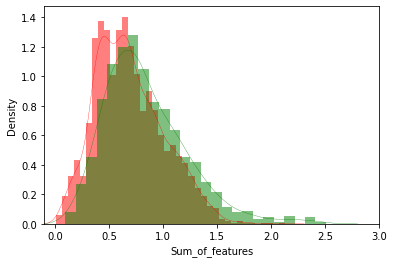

In [32]:
plt.xlim(-0.1,3)
# plt.ylim(0,1.6)

kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':0.3})

sns.distplot(df_first["Sum_of_features"],color="red", **kwargs)
sns.distplot(df_second["Sum_of_features"],color="green", **kwargs)

c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sum_of_features', ylabel='Density'>

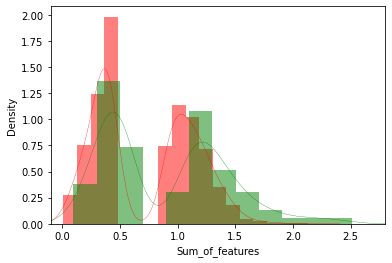

In [34]:
plt.xlim(-0.1,2.8)
# plt.ylim(0,1.6)
# plt.hist(df_first["Sum_of_features"],bins = 50, color='green', alpha=0.2, density= True)
# plt.hist(df_second["Sum_of_features"],bins = 50, color='red', alpha=0.2, density= True)

kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':0.3})

sns.distplot(df_one_adjusted["Sum_of_features"],color="red", **kwargs)
sns.distplot(df_two_adjusted["Sum_of_features"],color="green", **kwargs)

In [30]:
df_0.to_csv('between_cost_high.csv')

In [31]:
df_1.to_csv('between_cost_low.csv')

In [16]:
silhouette_score(data_scaled,membership)

0.583498760541941

In [17]:
df.loc[:,"Category"]=0
df.loc[hc.labels_==1, "Category"] = 1

In [ ]:
df.head(2)

In [18]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from statsmodels.regression.linear_model import OLSResults

In [19]:
feature_names = ['AnswerCount','CommentCount','Words_in_Title_Description','Tags_Count']
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]

In [20]:
scaler = MinMaxScaler()
features = df[feature_names]
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]
scaler.fit(features)
for i in nrm_feature_names:
    df[i] = 0
df[nrm_feature_names] = scaler.transform(features)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[nrm_feature_names], df["Category"], test_size=0.3, random_state=62)

In [22]:
lm_cluster_cost = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.383199
         Iterations 8


In [23]:
print(lm_cluster_cost.summary())

                           Logit Regression Results                           
Dep. Variable:               Category   No. Observations:                 3407
Model:                          Logit   Df Residuals:                     3403
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 Dec 2021   Pseudo R-squ.:                  0.3602
Time:                        12:28:30   Log-Likelihood:                -1305.6
converged:                       True   LL-Null:                       -2040.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Nrm_AnswerCount                   83.3144      3.954     21.071      0.000      75.565      91.064
Nrm_CommentCount                   5.1986      0.456     11.405      0.

In [32]:
df_python.drop(['Unnamed: 0', 'Score','ViewCount','FavoriteCount', 'Ans_Score','Auth_reputation','Editor_reputation', 'Accepted_Ans','Words_in_Title','title_tag_ratio','Creation_Days','Last_Edit_Days','Last_Activity_Days','Closed_Days'], axis=1, inplace=True)

In [33]:
df_python.head(1)

,AnswerCount,CommentCount,Words_in_Title_Description,Tags_Count,Category
0,2,1,295,4,0


In [24]:
y_pred = [1 if i else 0 for i in lm_cluster_cost.predict(X_test)>0.5]

In [25]:
data_summary = {}

Confusion Matrix: 
[[320  85]
 [133 923]]
Accuracy: 0.8507871321013005
Precision: 0.9156746031746031
Recall: 0.8740530303030303


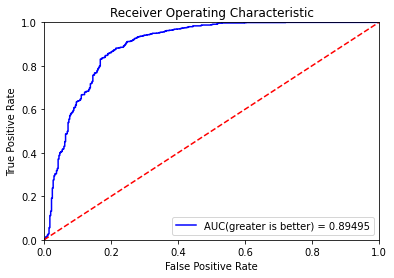

In [26]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_test, lm_cluster_cost.predict(X_test), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

data_summary["Exetrems_Model_Testing_Dataset"] = {}
data_summary["Exetrems_Model_Testing_Dataset"]["Accuracy"] = accuracy_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["Precision"] = precision_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["Recall"] = recall_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["AUC"] = auc(fpr, tpr)

Confusion Matrix: 
[[ 735  241]
 [ 313 2118]]
Accuracy: 0.8373936014088641
Precision: 0.8978380669775329
Recall: 0.8712464006581654


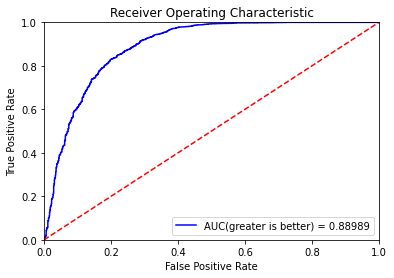

In [27]:
y_pred = [1 if i else 0 for i in lm_cluster_cost.predict(X_train)>0.5]
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_train, lm_cluster_cost.predict(X_train), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

data_summary["Exetrems_Model_Training_Dataset"] = {}
data_summary["Exetrems_Model_Training_Dataset"]["Accuracy"] = accuracy_score(y_train, y_pred)
data_summary["Exetrems_Model_Training_Dataset"]["Precision"] = precision_score(y_train, y_pred)
data_summary["Exetrems_Model_Training_Dataset"]["Recall"] = recall_score(y_train, y_train)
data_summary["Exetrems_Model_Training_Dataset"]["AUC"] = auc(fpr, tpr)

In [28]:
df_python = pd.read_csv('pythons.csv')

In [34]:
df_python.head(1)

,AnswerCount,CommentCount,Words_in_Title_Description,Tags_Count,Category
0,2,1,295,4,0


Confusion Matrix: 
[[ 8272    10]
 [11718     0]]
Accuracy: 0.4136
Precision: 0.0
Recall: 0.0


c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


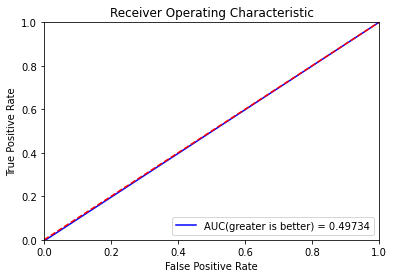

In [35]:
X_train, y_train = df_python[feature_names], df_python["Category"]
y_pred = [1 if i else 0 for i in lm_cluster_cost.predict(X_train)>0.5]
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_train, lm_cluster_cost.predict(X_train), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


data_summary["Exetrems_Model_Python_Dataset"] = {}
data_summary["Exetrems_Model_Python_Dataset"]["Accuracy"] = accuracy_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["Precision"] = precision_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["Recall"] = recall_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["AUC"] = auc(fpr, tpr)